# Solution 2
This solution performs way better than the first one. In this solution I used the following data structures and functions:
- <strong>solution</strong> is a numpy matrix where each row represents a knapsack. There actually is one more row than the number of kanpsacks and it represents the left-out items. So the row 0 contains the items which have not been taken. At first each item is left out, I also tried to start with a randomized solution but it could just not converge.
- <strong>tweak</strong> this time I do not swap a random number of random items, but a number which decreases with time. This way I can at first swap more items (exploration) and avoid getting stuck in a local maximum, then I start changing less items (exploitation) to find the best solution. 
- <strong>fitness</strong> is a function that computes the fitness of a solution. Invalid solutions have negative fitness.

In [2]:
import numpy as np
from random import randint, sample
from copy import deepcopy
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

In [3]:
NUM_KNAPSACKS = 2
NUM_ITEMS = 3
NUM_DIMENSIONS = 2

In [4]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

In [16]:
def compute_swaps_linear_decay(iteration: int, max_iterations: int) -> int:
    # Linear decay
    max_swaps = max(1, NUM_ITEMS // 2)  # max number of swaps
    progress = iteration / max_iterations
    num_swaps = max(1, int(max_swaps * (1 - progress)))
    
    num_swaps = min(num_swaps, NUM_ITEMS)

    return num_swaps

def compute_swaps_exponential_decay(iteration: int, max_iterations: int) -> int:
    # Exponential decay
    max_swaps = max(1, NUM_ITEMS // 2)  # max number of swaps
    decay_rate = 5
    progress = iteration / max_iterations
    num_swaps = max(1, int(max_swaps * math.exp(-decay_rate * progress)))
    
    num_swaps = min(num_swaps, NUM_ITEMS)

    return num_swaps

def compute_swaps_cooling_schedule(iteration: int, max_iterations: int) -> int:
    # Cooling schedule
    max_swaps = max(1, NUM_ITEMS // 2)  # max number of swaps
    initial_temp = 100
    final_temp = 1
    temp = initial_temp * (final_temp / initial_temp) ** (iteration / max_iterations)
    num_swaps = max(1, int(max_swaps * (temp / initial_temp)))
    
    num_swaps = min(num_swaps, NUM_ITEMS)

    return num_swaps


def adaptive_tweak(solution: np.array, iteration: int, max_iterations: int) -> np.array:
  s1 = deepcopy(solution)
  
  # number of items to swap decreases with time and depends on the current iteration
  num_swaps = compute_swaps_exponential_decay(iteration, max_iterations)

  # we start by picking the items to swap
  random_items = sample(range(0, NUM_ITEMS), num_swaps)

  for item in random_items:
    # consider 2 different random bags (if b=0 then we are choosing a left out item)
    b1 = np.where(solution[:, item])[0][0]
    while True:
      b2 = randint(0, NUM_KNAPSACKS)
      if b2 != b1:
        break
    # swap the item in the two bags
    s1[b1][item], s1[b2][item] = solution[b2][item], solution[b1][item]

  return s1


In [6]:
def fitness(solution: np.array) -> int:
  # at first we need to compute if the solution is feasible and if it is not we return a negative fitness
  if np.any(solution.sum(axis=0) > 1):
    return -2   # if an object apperas in multiple knapsacks than the algorithm itself is flawed
    
  for k in range(1, NUM_KNAPSACKS+1):        # for each knapsack
    
    items_in_knapsack = solution[k]

    if np.any(items_in_knapsack):           # if there are some items in the knapsack we can compute the total weight
        
        total_weight = WEIGHTS[items_in_knapsack].sum(axis=0)   # compute the total weight for each dimension
        
        if np.any(total_weight > CONSTRAINTS[k-1]):   
            return -1   # the solution violates the weight constraint


  # If the constraints are not violated then we can compute the fitness
  f = 0
  for i, item in enumerate(solution[0]):
    # all the items wich are not left out contribute to the fitness
    if not item:
      f += VALUES[i]    # add the value of the take item

  return f





In [7]:
def feasible(solution: np.ndarray) -> bool:
    # Check that the same object does not appear in multiple knapsacks
    if not np.all(solution.sum(axis=0) <= 1):
        return False
    # Check if the solution is valid
    for k in range(1, NUM_KNAPSACKS +1):
        if np.any(WEIGHTS[solution[k]].sum(axis=0) > CONSTRAINTS[k-1]):
            return False
    return True


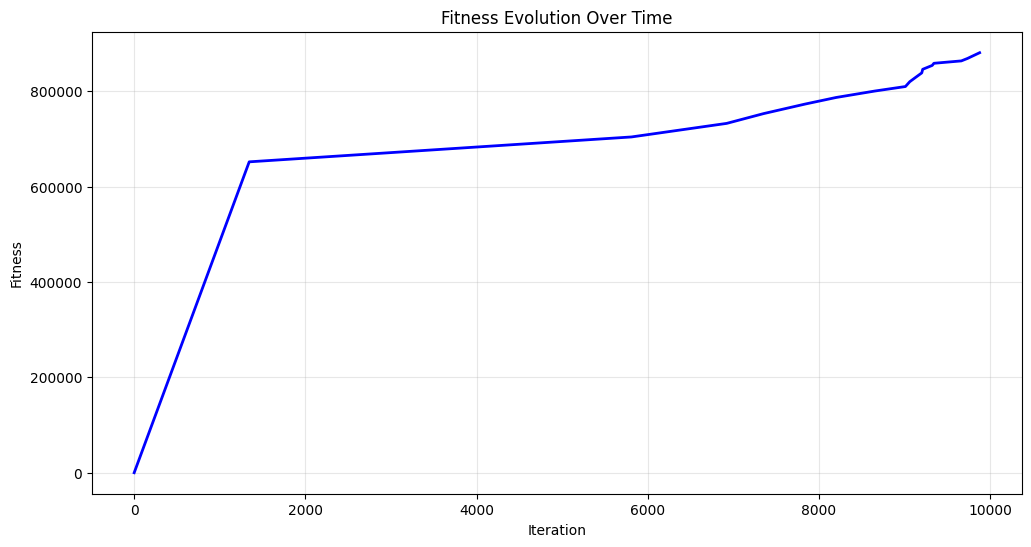


Final Result:
Best Fitness: 880875


In [17]:
# generate a starting solution where each elelement is not taken
# there is an additional knapsack that represents the left out items
solution = np.array([
    [False for _ in range(NUM_ITEMS)] for _ in range(NUM_KNAPSACKS + 1)], dtype=np.bool
)
# the row 0 of the solution represents the left out items

for i in range(NUM_ITEMS):
  solution[0][i] = True
  # to randomize it: solution[randint(0, NUM_KNAPSACKS-1)][i] = True

# choose the number of iterations
max_iterations = 10000

# Lists to track fitness evolution
fitness_history = []
iterations = []

f = fitness(solution)
fitness_history.append(f)
iterations.append(0)

# for x in tqdm(range(10000)):
for i in range(max_iterations):
  new_sol = adaptive_tweak(solution, i, max_iterations)
  f_new = fitness(new_sol)

  if f_new > f:
    f = f_new
    solution = new_sol
    fitness_history.append(f)
    iterations.append(i)
  elif f_new == f:
    solution = new_sol
    fitness_history.append(f)
    iterations.append(i)
  elif f_new == -2:
    raise Exception("Algorithm flaw: an item appears in multiple knapsacks")


# Plot the fitness evolution
plt.figure(figsize=(12, 6))
plt.plot(iterations, fitness_history, 'b-', linewidth=2)
plt.title('Fitness Evolution Over Time')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Result:")
print(f"Best Fitness: {f}")



In [ ]:
feasible(solution)

# Three problems for testing

In [ ]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

In [ ]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

In [18]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS,size=(NUM_KNAPSACKS, NUM_DIMENSIONS))